In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

<h1>1. Dataset Exploration & Understanding</h1>

In [3]:
# number of partipants
'''
In the description there are
48 participants
'''

# Days recorded per participant
min_date = None
max_date = None

for file in os.listdir("./dataset/calendar/"):
    df = pd.read_csv(f"./dataset/calendar/{file}")
    if min_date == None and max_date == None:
        min_date = df['DATE'].min()
        max_date = df['DATE'].max()
    else:
        if df['DATE'].min() < min_date:
            min_date = df['DATE'].min()

        if df['DATE'].max() > max_date:
            max_date = df['DATE'].max()

print(f"Earliest Date: {min_date}")
print(f"Latest Date: {max_date}")
print()


# Demographic diversity (age, gender)

'''
48 undergrads and grad students
doesn't specify gender
'''

# Total datapoints and labels
 
total_datapoints = 0
total_labels = 0
for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")
    total_datapoints += df.shape[0]
    total_labels += len(df['provider'].unique())

print(f"Total Datapoints: {total_datapoints}")
print(f"Total Labels: {total_labels}")
print()

# Datapoints per label

per_label = pd.Series(dtype="float64")  

for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")

    counts = (
        df.groupby("provider", dropna=False)
          .agg(rows=("provider", 'size'))
    )

    per_label = per_label.add(counts['rows'], fill_value=0)

per_label = per_label.astype(int).sort_values(ascending=False)
print(per_label)

# Input streams (accelerometer, gyro, annotations, etc.) 

'''
time
provider
network_type
accuracy
latitude
longitude
altitude
bearing
speed
travelstate
'''

Earliest Date: 03/27/2013
Latest Date: 6/8/2013

Total Datapoints: 202877
Total Labels: 117

wifi    187613
NaN      10744
cell      4520
dtype: int64


'\ntime\nprovider\nnetwork_type\naccuracy\nlatitude\nlongitude\naltitude\nbearing\nspeed\ntravelstate\n'

<h1>2. Annotation & Signal Exploration</h1>

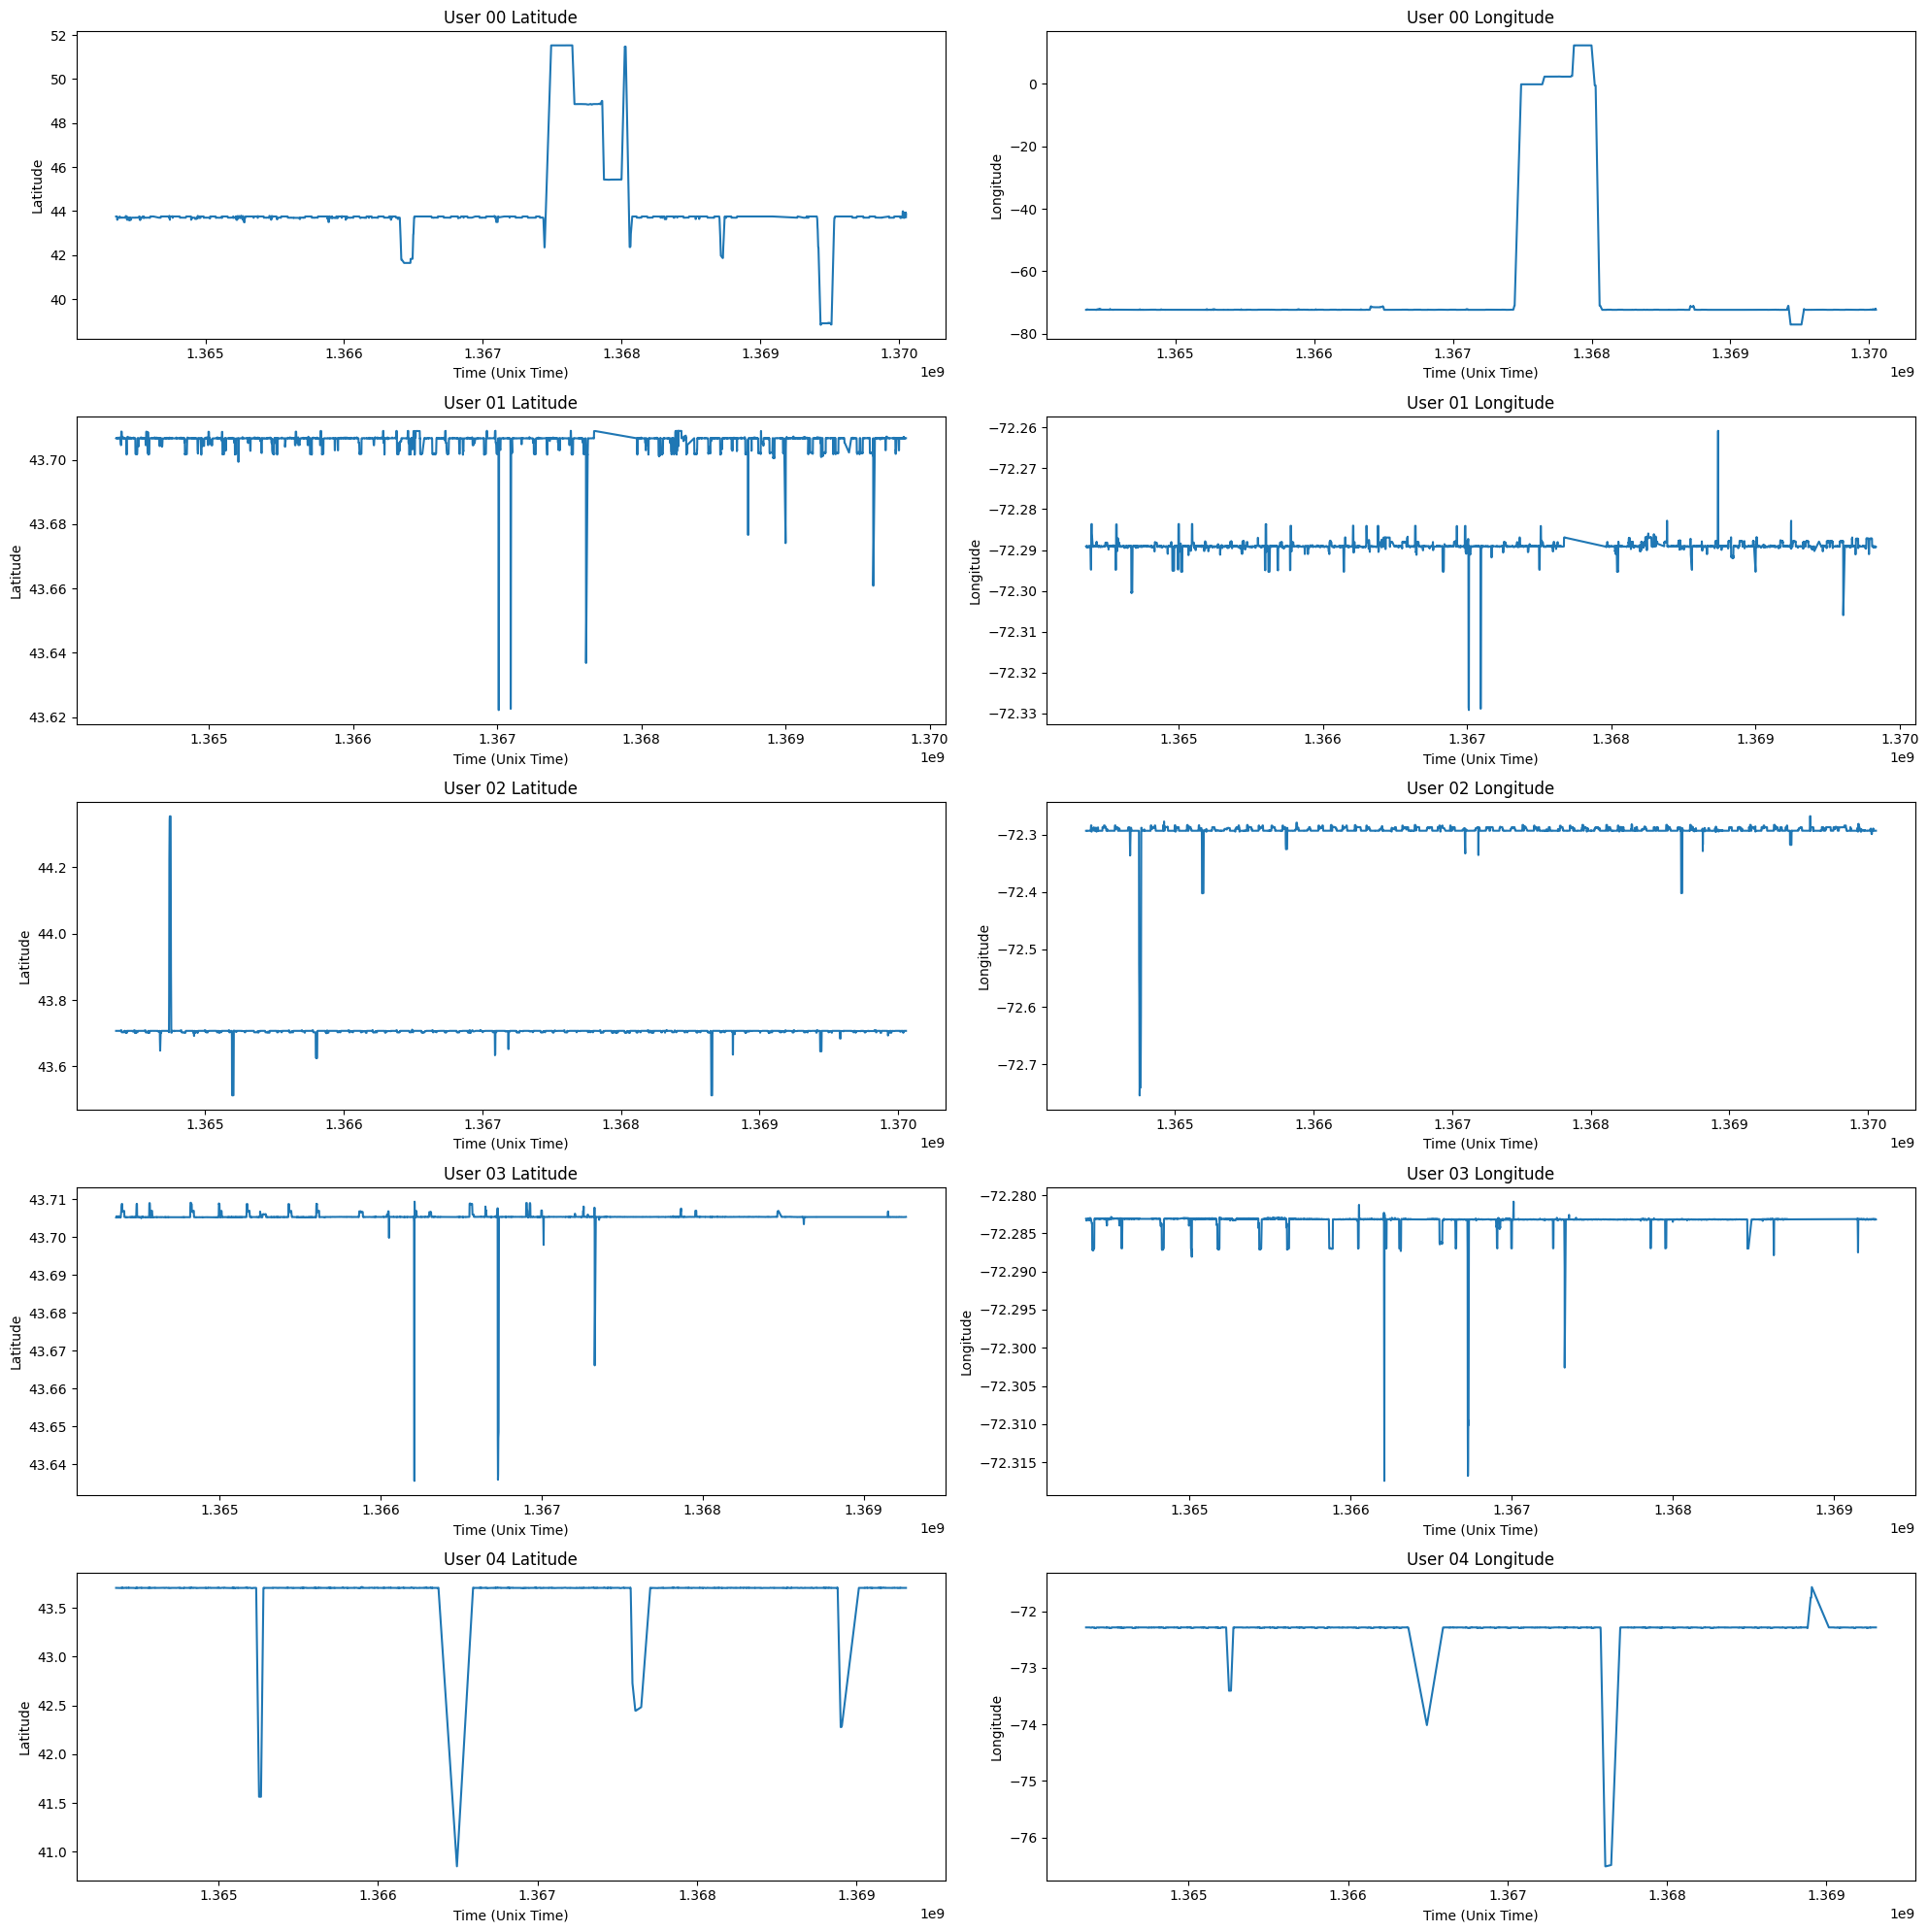

In [ ]:
# General latitude and longitude plots
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    axes[i][0].plot(df['time'], df['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(df['time'], df['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Longitude')  
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')  

    if i == 4:  # limit to first 5 users
        break

plt.tight_layout()
plt.show()

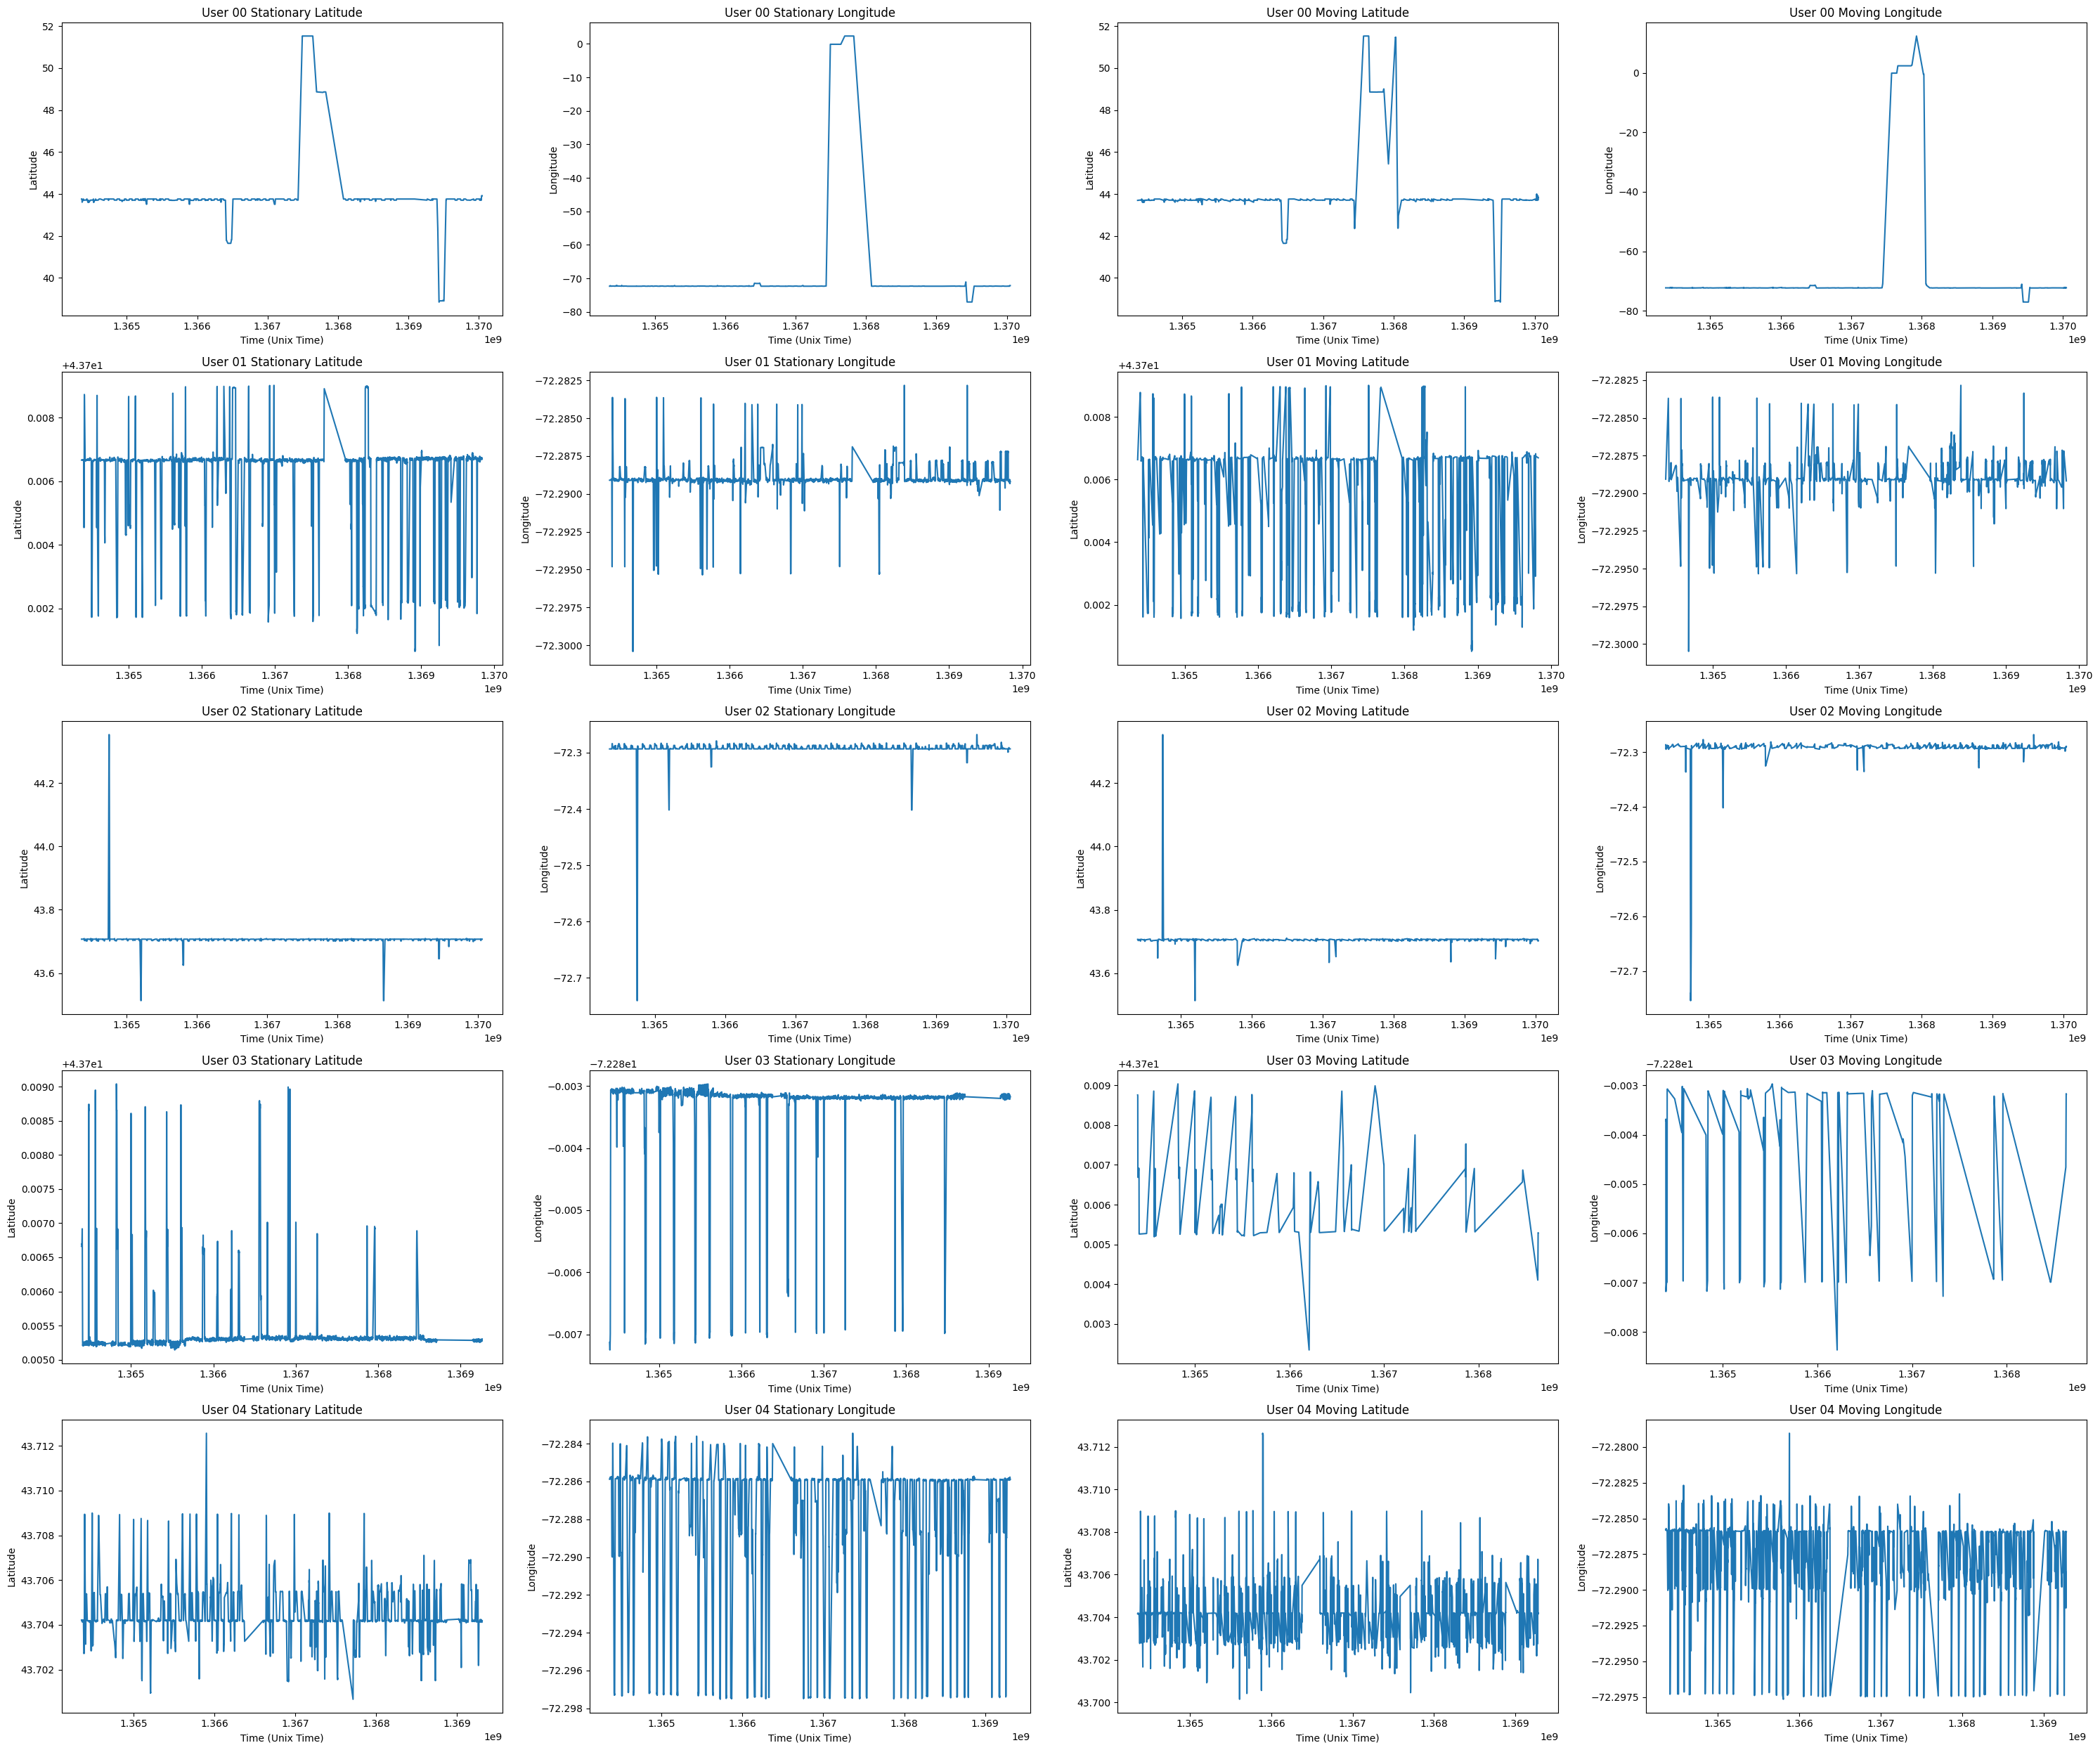

In [5]:
# Longitude and latitude plots based on travel state

fig, axes = plt.subplots(5, 4, figsize=(30,25))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    stationary = df[df['travelstate'] == 'stationary']
    axes[i][0].plot(stationary['time'], stationary['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Stationary Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(stationary['time'], stationary['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Stationary Longitude') 
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')

    moving = df[df['travelstate'] == 'moving']
    axes[i][2].plot(moving['time'], moving['latitude'])
    axes[i][2].set_title('User ' + str(user) + ' Moving Latitude')
    axes[i][2].set_xlabel('Time (Unix Time)')
    axes[i][2].set_ylabel('Latitude')
    axes[i][3].plot(moving['time'], moving['longitude'])
    axes[i][3].set_title('User ' + str(user) + ' Moving Longitude') 
    axes[i][3].set_xlabel('Time (Unix Time)')
    axes[i][3].set_ylabel('Longitude')
      

    if i == 4:  # preventing the graph from being too long since 2 travel states * 2 coords (lat/long) * 49 user graphs
        break 

plt.tight_layout()
plt.show()

<h1>3. Signal Preprocessing</h1>

In [57]:
# Resampling to uniform frequency

resampled_df = pd.DataFrame()

for path in os.listdir("./dataset/sensing/gps"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", sep=",", index_col=False, skipinitialspace=True)

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")

    df = (df.dropna(subset=["timestamp"])
            .sort_values("timestamp")
            .drop_duplicates("timestamp"))

    # Does a 1 min resample
    # Picks the first record with each min
    g = (df.set_index("timestamp")
           .resample("1min")
           .first()
           .reset_index())

    # Drop minutes that were created by resample but had no data
    g = g.dropna(subset=["time"])

    resampled_df = pd.concat([resampled_df, g], ignore_index=True)

# Makes sure there is no duplicates for each min
# If there is a duplicate then the earliest timestamp is kept
resampled_df = (resampled_df.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first"))

resampled_df

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,2013-03-27 04:17:00+00:00,1.364358e+09,network,wifi,81.68,43.705352,-72.290373,0.0,0.0,0.0,moving
208261,2013-03-27 04:40:00+00:00,1.364359e+09,network,wifi,20.00,43.705668,-72.290885,0.0,0.0,0.0,None
2,2013-03-27 05:00:00+00:00,1.364360e+09,network,wifi,20.00,43.705688,-72.290900,0.0,0.0,0.0,stationary
185123,2013-03-27 05:20:00+00:00,1.364362e+09,network,wifi,20.00,43.705661,-72.290922,0.0,0.0,0.0,stationary
156199,2013-03-27 05:40:00+00:00,1.364363e+09,network,wifi,20.00,43.705663,-72.290915,0.0,0.0,0.0,stationary
...,...,...,...,...,...,...,...,...,...,...,...
46275,2013-06-01 03:17:00+00:00,1.370057e+09,network,wifi,22.00,40.914261,-73.792014,0.0,0.0,0.0,stationary
277676,2013-06-01 03:27:00+00:00,1.370057e+09,network,wifi,36.00,40.914236,-73.792047,0.0,0.0,0.0,stationary
283462,2013-06-01 03:37:00+00:00,1.370058e+09,network,wifi,39.00,40.914250,-73.792028,0.0,0.0,0.0,stationary
231398,2013-06-01 03:47:00+00:00,1.370058e+09,network,wifi,39.00,40.914247,-73.792007,0.0,0.0,0.0,stationary


In [58]:
# Apply filtering (noise reduction)

filtered_df = resampled_df

# Noise reduction on the lat and lon values
filtered_df["filtered_latitude"]  = filtered_df["latitude"].rolling(3, center=True, min_periods=1).median()
filtered_df["filtered_longitude"] = filtered_df["longitude"].rolling(3, center=True, min_periods=1).median()

filtered_df.head(10)

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,filtered_latitude,filtered_longitude
0,2013-03-27 04:17:00+00:00,1.364358e+09,network,wifi,81.68,43.705352,-72.290373,0.0,0.0,0.0,moving,43.705510,-72.290629
208261,2013-03-27 04:40:00+00:00,1.364359e+09,network,wifi,20.00,43.705668,-72.290885,0.0,0.0,0.0,None,43.705668,-72.290885
2,2013-03-27 05:00:00+00:00,1.364360e+09,network,wifi,20.00,43.705688,-72.290900,0.0,0.0,0.0,stationary,43.705668,-72.290900
185123,2013-03-27 05:20:00+00:00,1.364362e+09,network,wifi,20.00,43.705661,-72.290922,0.0,0.0,0.0,stationary,43.705663,-72.290915
156199,2013-03-27 05:40:00+00:00,1.364363e+09,network,wifi,20.00,43.705663,-72.290915,0.0,0.0,0.0,stationary,43.705661,-72.290915
231405,2013-03-27 06:00:00+00:00,1.364364e+09,network,wifi,20.00,43.705661,-72.290896,0.0,0.0,0.0,None,43.705663,-72.290901
242976,2013-03-27 06:20:00+00:00,1.364365e+09,network,wifi,20.00,43.705677,-72.290901,0.0,0.0,0.0,stationary,43.705661,-72.290901
40502,2013-03-27 06:40:00+00:00,1.364366e+09,network,wifi,20.00,43.705641,-72.290914,0.0,0.0,0.0,stationary,43.705671,-72.290901
127278,2013-03-27 07:00:00+00:00,1.364368e+09,network,wifi,20.00,43.705671,-72.290884,0.0,0.0,0.0,stationary,43.705671,-72.290894
277689,2013-03-27 07:20:00+00:00,1.364369e+09,network,wifi,20.00,43.705680,-72.290894,0.0,0.0,0.0,stationary,43.705671,-72.290894


In [45]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

combined_df = pd.DataFrame()
gps_dir = Path("./dataset/sensing/gps")

for path in sorted(gps_dir.glob("*.csv")):           # safer than os.listdir
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", sep=",", index_col=False, skipinitialspace=True)

    # If 'time' ended up as the index in some files, bring it back as a column
    if "time" not in df.columns and (df.index.name == "time"):
        df = df.reset_index()

    # Build timestamp
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")

    # Clean & sort
    df = (df.dropna(subset=["timestamp"])
            .sort_values("timestamp")
            .drop_duplicates("timestamp"))

    # 1-minute resample: pick the first record within each minute
    g = (df.set_index("timestamp")
           .resample("1min")
           .first()
           .reset_index())

    # Drop minutes that were created by resample but had no data
    g = g.dropna(subset=["time"])

    # (optional) keep track of source
    g["source_file"] = path.name

    # Accumulate
    combined_df = pd.concat([combined_df, g], ignore_index=True)

# After loop: if multiple files have the same minute, keep the earliest
if not combined_df.empty:
    combined_df = (combined_df.sort_values("timestamp")
                              .drop_duplicates(subset=["timestamp"], keep="first"))

combined_df


,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,source_file
0,2013-03-27 04:17:00+00:00,1.364358e+09,network,wifi,81.68,43.705352,-72.290373,0.0,0.0,0.0,moving,gps_u00.csv
208261,2013-03-27 04:40:00+00:00,1.364359e+09,network,wifi,20.00,43.705668,-72.290885,0.0,0.0,0.0,None,gps_u45.csv
2,2013-03-27 05:00:00+00:00,1.364360e+09,network,wifi,20.00,43.705688,-72.290900,0.0,0.0,0.0,stationary,gps_u00.csv
185123,2013-03-27 05:20:00+00:00,1.364362e+09,network,wifi,20.00,43.705661,-72.290922,0.0,0.0,0.0,stationary,gps_u41.csv
156199,2013-03-27 05:40:00+00:00,1.364363e+09,network,wifi,20.00,43.705663,-72.290915,0.0,0.0,0.0,stationary,gps_u33.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
46275,2013-06-01 03:17:00+00:00,1.370057e+09,network,wifi,22.00,40.914261,-73.792014,0.0,0.0,0.0,stationary,gps_u08.csv
277676,2013-06-01 03:27:00+00:00,1.370057e+09,network,wifi,36.00,40.914236,-73.792047,0.0,0.0,0.0,stationary,gps_u58.csv
283462,2013-06-01 03:37:00+00:00,1.370058e+09,network,wifi,39.00,40.914250,-73.792028,0.0,0.0,0.0,stationary,gps_u59.csv
231398,2013-06-01 03:47:00+00:00,1.370058e+09,network,wifi,39.00,40.914247,-73.792007,0.0,0.0,0.0,stationary,gps_u49.csv


<h1>4. Windowing Strategies</h1>

<h1>5. Feature Extraction & Analysis</h1>

<h1>6. Modeling & Evaluation</h1>